In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import math
import matplotlib.pyplot as plt
# import GPy
from utils import plot_heatmap

data = xr.open_dataset("data/delhi_cpcb_2022.nc")
# data = xr.open_dataset("delhi_cpcb_2022.nc")
# data = pd.read_csv("../data/final_data.csv.gz")
data

<xarray.Dataset>
Dimensions:    (station: 40, time: 8783)
Coordinates:
  * station    (station) object 'Alipur, Delhi - DPCC' ... 'Wazirpur, Delhi -...
  * time       (time) datetime64[ns] 2022-01-01T00:30:00 ... 2023-01-01T22:23:30
    latitude   (station) float64 ...
    longitude  (station) float64 ...
Data variables: (12/21)
    From Date  (station, time) datetime64[ns] ...
    To Date    (station, time) datetime64[ns] ...
    PM2.5      (station, time) float64 ...
    PM10       (station, time) float64 ...
    NO         (station, time) float64 ...
    NO2        (station, time) float64 ...
    ...         ...
    WD         (station, time) float64 ...
    SR         (station, time) float64 ...
    BP         (station, time) float64 ...
    AT         (station, time) float64 ...
    RF         (station, time) float64 ...
    TOT-RF     (station, time) float64 ...

In [2]:
df_ = data.to_dataframe().reset_index()
# df_ = 
df = df_[df_["time"]=="2022-03-01 01:30:00"]
df = df.dropna(subset=["PM2.5"])
df = df.rename(columns={"RH": "relative_humidity", "WS": "wind_speed", "WD": "wind_direction", "SR": "solar_radiation", "BP": "pressure", "AT": "temperature", "RF": "rain_fall", "TOT-RF": "total_rainfall"})

In [3]:
df

,station,time,From Date,To Date,PM2.5,PM10,NO,NO2,NOx,NH3,...,relative_humidity,wind_speed,wind_direction,solar_radiation,pressure,temperature,rain_fall,total_rainfall,latitude,longitude
1417,"Alipur, Delhi - DPCC",2022-03-01 01:30:00,2022-03-01 01:00:00,2022-03-01 02:00:00,70.00,150.00,3.78,43.38,26.15,3.42,...,78.22,NaN,139.97,4.55,993.40,11.43,0.0,0.0,28.815329,77.153010
10200,"Anand Vihar, Delhi - DPCC",2022-03-01 01:30:00,2022-03-01 01:00:00,2022-03-01 02:00:00,52.50,144.00,11.88,30.62,26.02,15.82,...,68.95,0.30,246.25,8.95,973.65,15.45,NaN,0.0,28.647622,77.315809
18983,"Ashok Vihar, Delhi - DPCC",2022-03-01 01:30:00,2022-03-01 01:00:00,2022-03-01 02:00:00,79.00,134.00,7.47,67.17,41.80,50.77,...,71.30,0.38,206.90,5.43,987.17,13.82,0.0,0.0,28.695381,77.181665
27766,"Aya Nagar, Delhi - IMD",2022-03-01 01:30:00,2022-03-01 01:00:00,2022-03-01 02:00:00,73.94,159.30,22.49,26.28,48.80,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,28.470691,77.109936
36549,"Bawana, Delhi - DPCC",2022-03-01 01:30:00,2022-03-01 01:00:00,2022-03-01 02:00:00,135.00,245.00,4.80,20.65,25.43,41.45,...,81.62,0.62,22.33,5.70,993.12,12.30,0.0,0.0,28.776200,77.051074
45332,"Burari Crossing, Delhi - IMD",2022-03-01 01:30:00,2022-03-01 01:00:00,2022-03-01 02:00:00,52.81,158.79,NaN,NaN,0.00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,28.725650,77.201157
54115,"CRRI Mathura Road, Delhi - IMD",2022-03-01 01:30:00,2022-03-01 01:00:00,2022-03-01 02:00:00,109.78,305.51,99.26,18.77,118.06,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,28.551201,77.273574
62898,"Chandni Chowk, Delhi - IITM",2022-03-01 01:30:00,2022-03-01 01:00:00,2022-03-01 02:00:00,40.15,247.45,28.02,128.16,89.75,81.71,...,63.23,1.21,78.50,NaN,999.28,17.39,0.0,0.0,28.656756,77.227234
71681,"DTU, Delhi - CPCB",2022-03-01 01:30:00,2022-03-01 01:00:00,2022-03-01 02:00:00,79.83,145.75,7.80,24.82,19.45,23.85,...,77.85,0.45,130.91,NaN,NaN,NaN,NaN,0.0,28.750050,77.111261
80464,"Dr. Karni Singh Shooting Range, Delhi - DPCC",2022-03-01 01:30:00,2022-03-01 01:00:00,2022-03-01 02:00:00,78.50,218.75,73.85,95.58,111.05,14.77,...,72.95,0.88,294.10,5.20,988.48,11.15,0.0,0.0,28.498571,77.264840


In [4]:
from sklearn.ensemble import RandomForestRegressor

def rf(X_train, y_train, X_test):

    rf = RandomForestRegressor()
    rf.fit(X_train, y_train)
    pred_y = rf.predict(X_test)
    
    return pred_y

2022-01-01 00:30:00	83.88720949163448


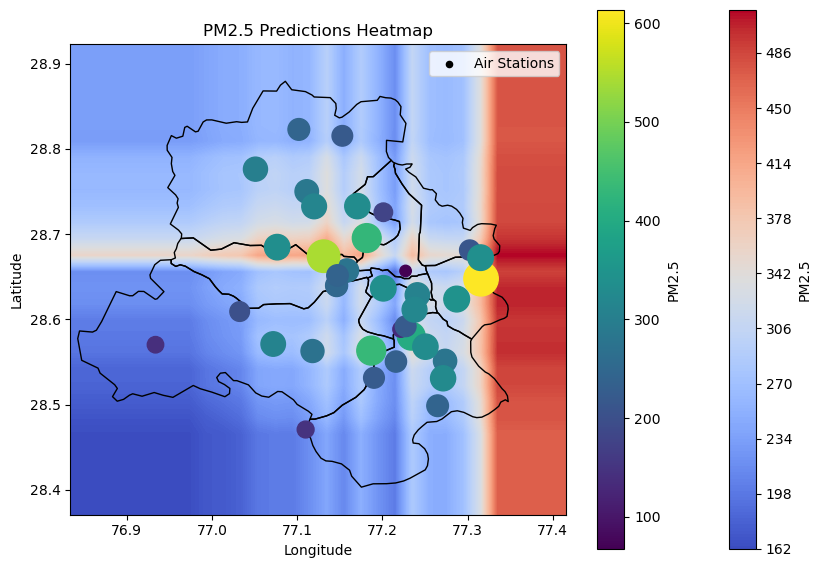

2022-02-01 00:30:00	48.20983000000006


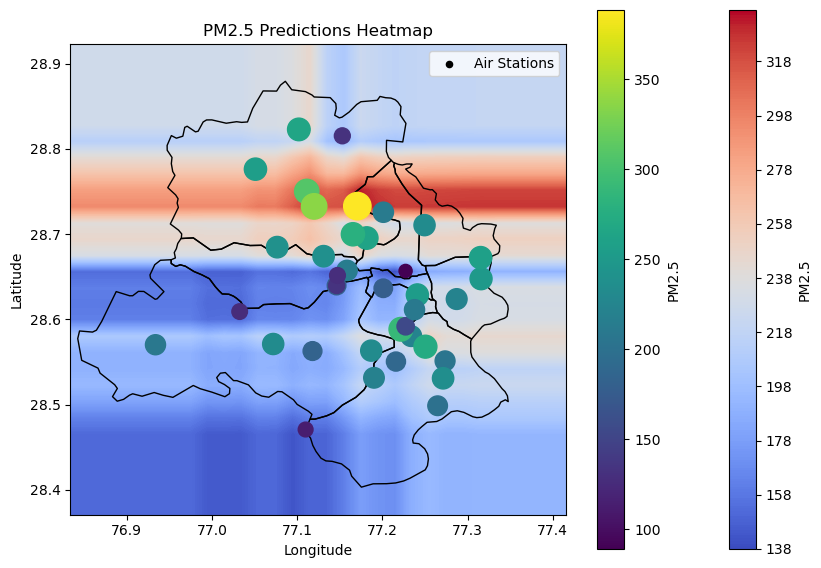

2022-03-01 00:30:00	23.936133947368436


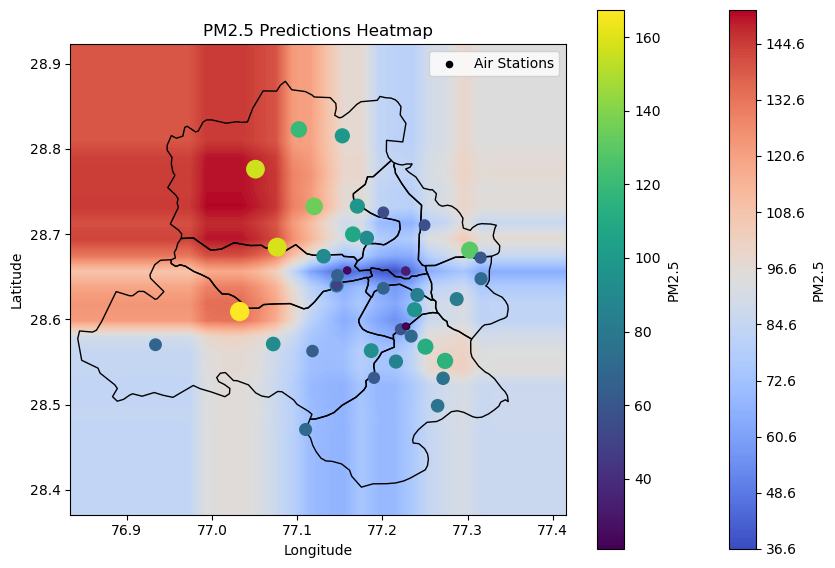

2022-04-01 00:30:00	31.065559034749043


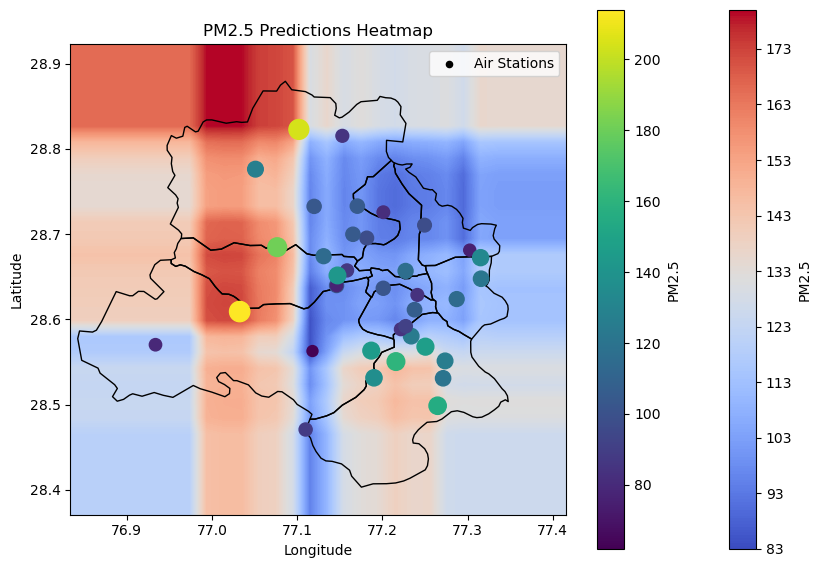

2022-05-01 00:30:00	43.01896578947369


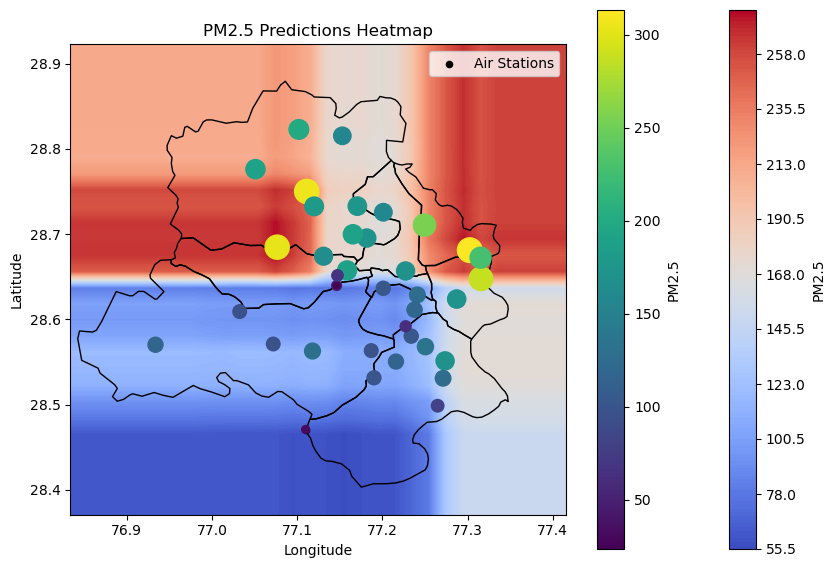

2022-06-01 00:30:00	44.51753263157895


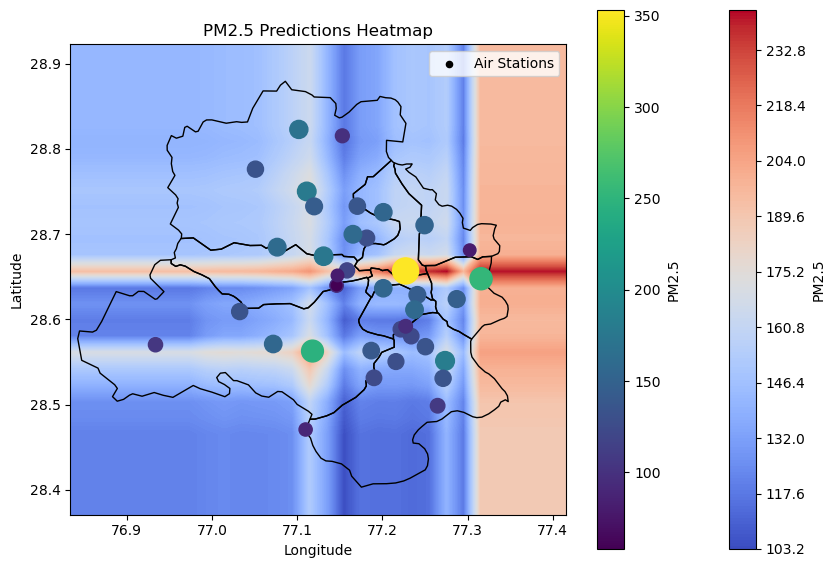

2022-07-01 00:30:00	8.780014705882353


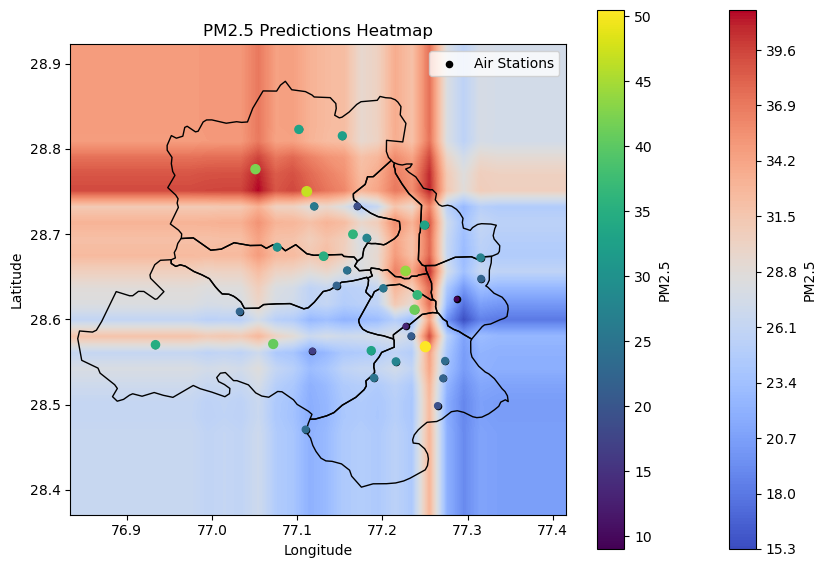

2022-08-01 00:30:00	10.62448783783784


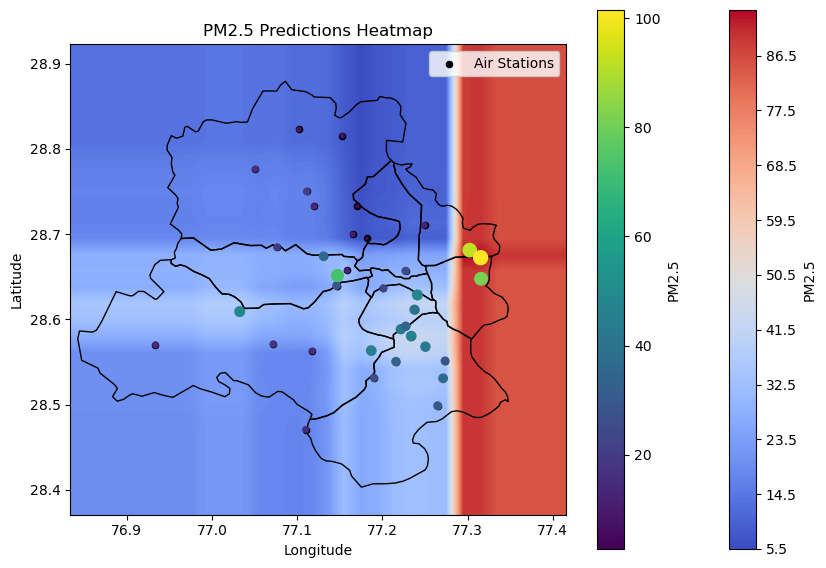

2022-09-01 00:30:00	13.208163095238094


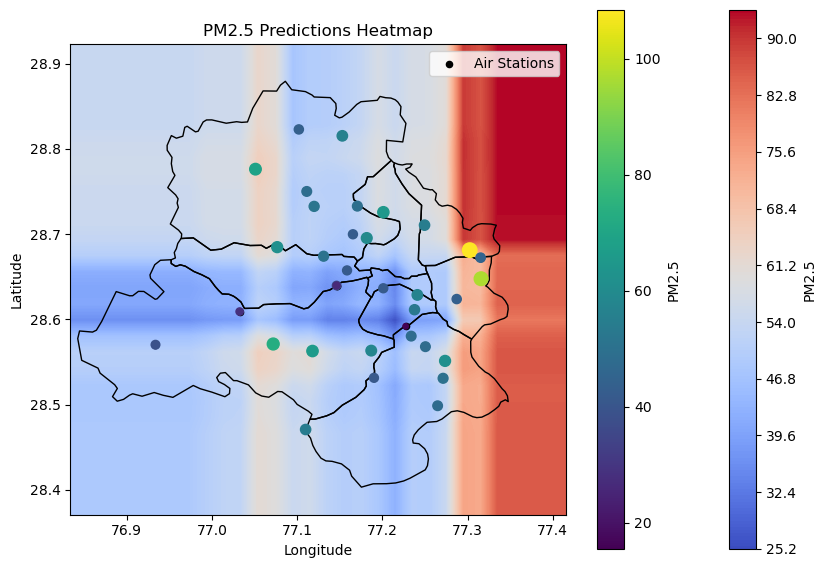

2022-10-01 00:30:00	20.04271471428572


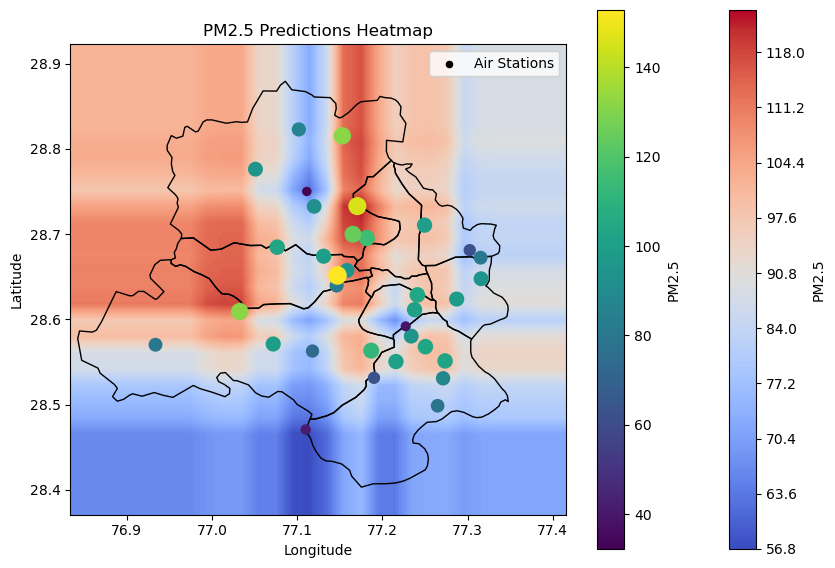

2022-11-01 00:30:00	81.59628702702697


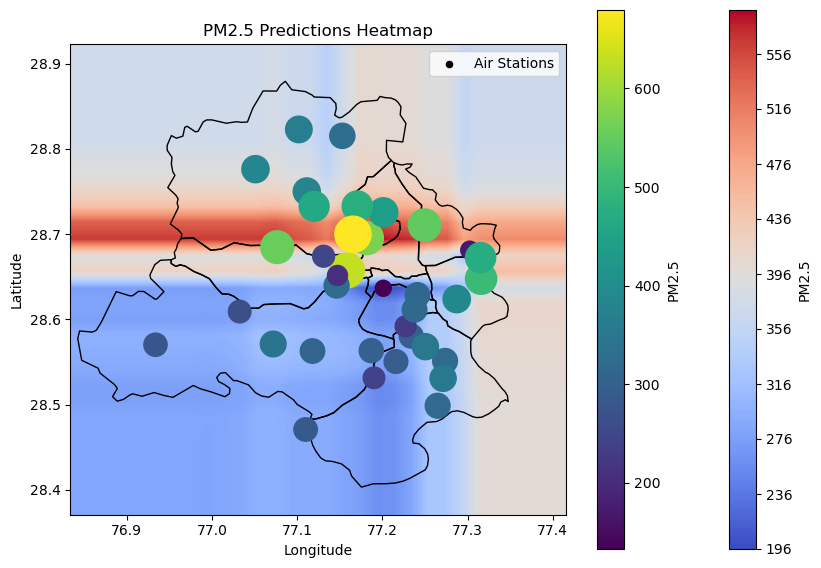

2022-12-01 00:30:00	58.154534247104245


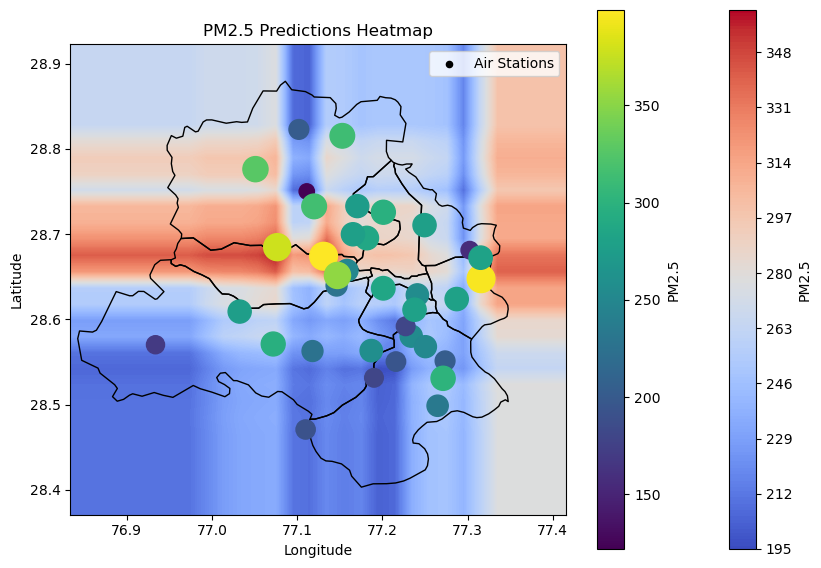

In [5]:
p = pd.date_range(start='2022-01-01 00:30:00', end='2022-12-01 00:30:00', freq = '1MS').to_frame(name='dates')
rf_rmse = []
rf_preds = []

for i in p['dates']:
    df = df_[df_["time"]==i]
    df = df.dropna(subset=["PM2.5"])
    print(i, end = '\t')
    rf_rmse_i = []
    
    #Leave One Out Cross Validation
    for station in df.station.unique():
        train = df[df['station'] != station]
        test = df[df['station'] == station]
        X_train = train[['latitude', 'longitude']]
        X_test = test[['latitude', 'longitude']]
        y_train = train['PM2.5']
        y_test = test['PM2.5']
        pred = rf(X_train, y_train, X_test)
        rf_rmse_i.append(np.sqrt((y_test - pred)**2))
    
    #RMSE
    rf_rmse.append(np.mean(rf_rmse_i))
    print(rf_rmse[-1])
    
    #Heatmap
    latitudes = np.array(df['latitude'])
    longitudes = np.array(df['longitude'])
    g_lat = np.linspace(latitudes.min()-0.1, latitudes.max()+0.1, 30)
    g_long = np.linspace(longitudes.min()-0.1, longitudes.max()+0.1, 30)
    lat_grid, lon_grid = np.meshgrid(g_lat, g_long)
    
    train = df[['latitude', 'longitude', 'PM2.5']]
    test = pd.DataFrame({'longitude':lon_grid.flatten(),
                     'latitude':lat_grid.flatten()})
    
    X_train = train[['latitude', 'longitude']]
    y_train = train['PM2.5']
    X_test = test[['latitude', 'longitude']]
    
    preds = rf(X_train, y_train, X_test)
    test['PM2.5'] = preds
    plot_heatmap(lon = np.array(test['longitude']), lat = np.array(test['latitude']), values = test['PM2.5'].values, df = df)